# **Exercise 2**: Analyze your SFINCS model results for Charleston

In this exercise we will analyze the results of the SFINCS model for the area around Charleston that you just ran. 
After doing this exercise you will know how to do a basic visualization of the output. 

We will follow the following steps to inspect the model results:

- Step 1: Load simulated model
- Step 2: Model output
- Step 3: Plot time-series
- Step 4: Plot map output
- Step 5: Quick video

## Import dependencies

Before anything else we need to import the required packages:

In [1]:
from pathlib import Path

import hydromt
import numpy as np
from hydromt_sfincs import SfincsModel

## **Step 1:** Load simulated model
The first step is to load the simulated model results by providing:
 - `root_folder`: Folder where the model was saved. Path is relative to current working directory. We are loading in the model **sfincs_charleston_hugo**

In [2]:
root_folder = Path(r"../models/sfincs_charleston_hugo")
print(f"Reading model from {root_folder}")

sf = SfincsModel(root=root_folder, mode="r")
sf.read()

Reading model from ..\models\sfincs_charleston_hugo


## **Step 2:** Model output

In the previous notebook we have run the SFINCS simulation, and looked at the logfile of the model.
Now we will look at the actual output of the model, these are saved in the Netcdf files called:
 - `sfincs_map.nc`: File for all the spatially varying data like the water levels in the entire domain.
 - `sfincs_his.nc`: (optional) File with the time-series at observations points, in case these were provided.

We will now load in the results using HydroMT, and look at what data is available:

In [ ]:
# make sure the model output files exist
if (
    not Path(root_folder, "sfincs_map.nc").exists()
    or not Path(root_folder, "sfincs_his.nc").exists()
):
    raise RuntimeError(
        "Model output files do not exist, run the model first "
        "(see notebook 'SFINCS_course_01_run_your_first_model.ipynb')"
    )

sf.read_results()
print(sf.results.keys())

#zs - hourly
#zsmax - max of the day (because the max might )

dict_keys(['inp', 'msk', 'zb', 'zs', 'zsmax', 'total_runtime', 'average_dt', 'status', 'point_zb', 'point_zs'])


Available are, from sfincs_map.nc:
 - `inp`: All input settings provided to the sfincs input file
 - `msk`: Mask of active cells, will be explained later 
 - `zb`: Bed level elevation 
 - `zs`: Water level in time on the whole grid 
 - `zsmax`: Maximum water level observed during a certain interval (e.g. every day) on the whole grid 
 - `total_runtime`: Total simulation time, as can also be read in 'sfincs_log.txt'   
 - `average_dt`: Average model time step, as can also be read in 'sfincs_log.txt'  

Available are, from sfincs_his.nc:
 - `point_zb`: Bed level elevation at specific observation points
 - `point_zs`: Water level in time at specific observation points

 *Hint*: More information about e.g. units can be found in the [online SFINCS documentation](https://sfincs.readthedocs.io/en/latest/output.html#output-description) 

## **Step 3:** Plot time-series
Let's have a look at the time-series of the first observation point (obs #0), at 'Charleston river mouth':

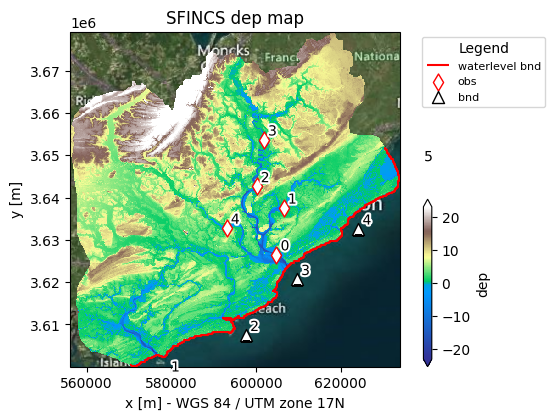

In [4]:
_ = sf.plot_basemap(variable="dep", bmap="sat")

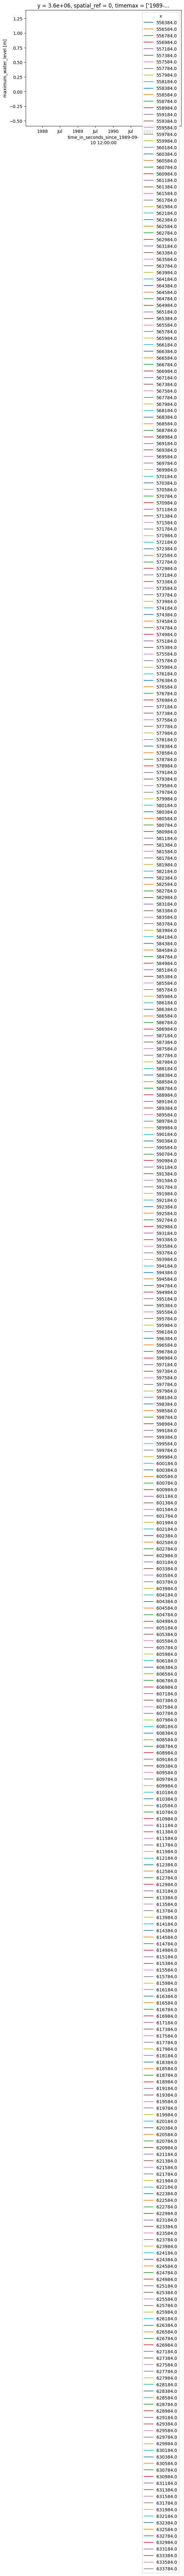

In [ ]:
# FILL IN THE ID OF THE OBSERVATION POINT BASED ON THE PLOT ABOVE
# bnd_index =  # first observation point
# bnd_index = 0
sf.results["point_zs"][:, 0].plot.line(x="time")
sf.results["point_zs"][:, 4].plot.line(x="time")
# sf.results["zsmax"][:, bnd_index].plot.line(x="timemax")

### Question 1

1a) What is the maximum water level in the mouth of the river?

1b) And how much is this in Ashley River? (*Hint* Update the code above)

1c) Why do you think there is a difference?

### Fill out your answers:

1a)

3.1 m

1b)

3.0 m

1C)

The mouth is closer to the sea - where the water level rise is initiated.The peak occurs slightly later too farther inland.

### Question 2

2a) Can you estimate the tidal contribution to that water level?

2b) And the additional storm surge?

### Fill out your answers:

2a)

looking at the seeming tidal trend, it contributed about 1 m to the flood event.

2b)

The storm surge would then have added 2 meters.

## **Step 4:** Plot water depth map

Now we can plot compute and plot the maximum water depth. 
As the model output saves the water level referenced to the vertical datum we need to convert this to water depth relative to the local bed level.
To do this we need to downscale the water level using the subgrid resolution bed levels.
The image below illustrates how the water depth can vary within a grid cell with constant water level due to subgrid variations in bed level.

![Subgrid illustration](https://sfincs.readthedocs.io/en/latest/_images/Figure_subgrid_tables.png)

When opening the maximum water level and the bed level, we can see that these are loaded by HydroMT as [Xarray DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html).
The dimension of the water levels is [timemax, y, x] and the dimensions of the bed level is [y, x]. By taking the max over all timemax timesteps we reduce the waterlevel to a 2D [x, y] array.

In [33]:
# variable to plot: maximum water depth (see STEP 2)
waterlevel_var = "zsmax"

# read the maximum water level
zsmax = sf.results[waterlevel_var].max(dim="timemax") # maximum water level
zsmax

#to get global max

<xarray.DataArray 'zsmax' (y: 394, x: 388)> Size: 611kB
dask.array<_nanmax_skip-aggregate, shape=(394, 388), dtype=float32, chunksize=(394, 388), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3kB 3.6e+06 3.601e+06 ... 3.679e+06 3.679e+06
  * x            (x) float64 3kB 5.564e+05 5.566e+05 ... 6.336e+05 6.338e+05
    spatial_ref  int64 8B 0
Attributes:
    units:          m
    standard_name:  maximum of sea_surface_height_above_reference_level
    long_name:      maximum_water_level

Text(0.5, 1.0, 'SFINCS maximum water depth (downscaled)')

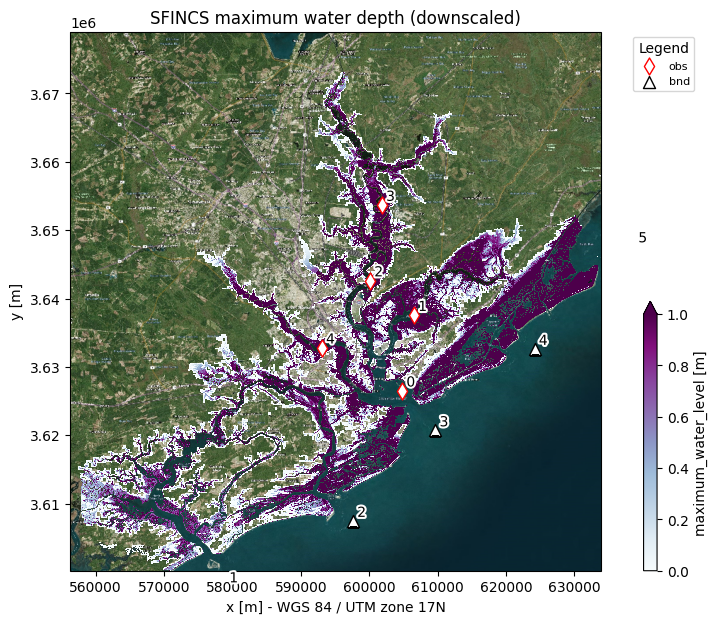

In [34]:
# We can use the subgrid resolution topography to downscale the maximum water level to water depth at the subgrid resolution
# First, we read the subgrid resolution topography and check if the file exists
dep_subgrid_file = Path(sf.root, "subgrid", "dep_subgrid.tif")
if not dep_subgrid_file.exists():
    raise FileNotFoundError(f"Subgrid file {dep_subgrid_file} does not exist")
dep_subgrid = hydromt.open_raster(dep_subgrid_file, nodata=np.nan) # elevation at subgrid resolution

# calculate the maximum water depth (hmax) as the difference between 
# the maximum water level (zsmax) and the elevation (dep)
zsmax_subgrid = zsmax.raster.reproject_like(dep_subgrid, method="nearest")  # reproject to subgrid resolution
hmax_subgrid = np.maximum(0, zsmax_subgrid - dep_subgrid).round(2).astype(np.float32) # maximum water depth
# Here, we assume that all areas with a negative depth are permanent water bodies
# This is a strong simplification. It is better to use a more sophisticated approach by digitizing permanent water bodies from satellite images in GIS software.
permament_water = dep_subgrid < 0 
hmax_subgrid = hmax_subgrid.where(~permament_water, np.nan) # mask areas with permanent water
# update (geospatial) metadata
hmax_subgrid.raster.set_crs(dep_subgrid.raster.crs)
hmax_subgrid.raster.set_nodata(np.nan)
hmax_subgrid.name = "max water depth"
hmax_subgrid.attrs["units"] = "m"

fig, ax = sf.plot_basemap(
    fn_out="max_depth_subgrid.png",  # save figure to mod.root/figs/hmax.png
    variable=hmax_subgrid,
    plot_bounds=False,
    bmap="sat",
    zoomlevel=12,
    figsize=(11, 7),
    vmin=0,  # set minimum value for colorbar
    vmax=1,  # set maximum value for colorbar
    cmap="BuPu",
)
ax.set_title("SFINCS maximum water depth (downscaled)")

### Question 3

3a) Can you plot the water level during the peak of the storm? (TIP: use variable 'zs' rather than 'zsmax')


3b) Is a much larger area flooded then?


### Fill out your answers:

3a)

Yes

3b)

There doesn't appear to be a more or less flooded area.

## **Step 5:** Quick video

We can show the water levels in a quick movie.
After running the script, scroll down and hit play!

In [ ]:
# local script imports 
import sfincs_plotting

# Get water depth variable from results
da_h = sf.results["zs"] - sf.grid["dep"]
da_h.name = "water depth"
da_h.attrs["units"] = "m"

# Make animation
sfincs_plotting.make_animation(
    da_h=da_h.where(da_h > 0.01),  # mask out dry cells
    geoms=sf.geoms,
    bmap="sat",
    figsize=(7, 7),
    vmin=0,  # set min and max values for colorbar
    vmax=3,  # set min and max values for colorbar
    cmap="BuPu",  # set colormap
)

### Question 4

4a) From what direction comes the largest flood wave?

4b) Do you think Hurricane Hugo (1989), that created this storm surge, made landfall west or east from the city of Charleston?

4c) Do you think the impact would have been more intense if the hurricane would have made landfall more to the south?

*Hint* - you can see the track here:  https://coast.noaa.gov/hurricanes/ if you type in 'Hurricane Hugo'

### Fill out your answers:

4a)

4b)

4c)

## **BONUS:** Change some settings and re-analyse the results:
- Run the simulation with advection and compare the results with the base run, how big is the difference? And how much slower did the simulation become?
- Run the model in the folder 'Charleston_subgrid_example_allforcing' that contains more forcing. What extra forcings are added? And do you see the effect in the results? How much additional water level increase do you see at the mouth of the river because of the local wind setup? How much is the flooding reduced in extent/water level due to the weir?

## **Done**

Congrats, you did your first analysis of SFINCS model results!